# Advanced Model Handling in TIAToolbox

Click to open in: \[[GitHub](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07-advanced-modeling.ipynb)\]\[[Colab](https://colab.research.google.com/github/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07-advanced-modeling.ipynb)\]



## About this notebook

This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory. To connect with Colab, click on one of the two blue checkboxes above. Check that "colab" appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on GitHub or Colab, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab, set up your Python environment, as explained in the
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.



## About this demo

This notebook demonstrates advanced techniques on how to use TIAToolbox models with your current workflow
and how you can integrate your solutions into the TIAToolbox model framework. By doing so, you will be able to utilize extensively tested TIAToolbox tools in your experiments and speed up your computational pathology research.
Notice, in this notebook, we assume that you are an advanced user of TIAToolbox who is familiar with object-oriented programming concepts in Python and TIAToolbox models framework. To make yourself familiar with how TIAToolbox models work, we invite you to have a look at our example notebooks on [patch classification](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/05-patch-prediction.ipynb) and [semantic segmentation](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/06-semantic-segmentation.ipynb) in histology images/WSIs or you can study the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html#deep-learning-models) and the [code base](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models) on these matters.

When thinking of either using the TIAToolbox models in your application or expanding it to fit your needs, several scenarios can be imagined. The most common scenarios and their solutions are briefly listed below:

1. Instead of pretrained models embedded in TIAToolbox's
   repository, you want to use your own deep learning model
   (in Pytorch) in the TIAToolbox prediction workflow.
   - You can create your model by following the same protocol      as the TIAToolbox model does and provide it to the
     predictor.
1. Your input data is of an exotic form which the TIAToolbox
   data stream functionality does not support by default.
   - You will need to subclass the `WSIStreamDataset` or
     related classes in the TIAToolbox to roll your own input
     form and provide the class for predictor construction.

Note that the output should still fit with existing deep learning models in the toolbox.

Other cases can be imagined, like when the existing _merging strategy_ in the TIAToolbox does not fit your method for WSI processes. In this case, it is very likely that you have to overwrite a large portion of the existing workflow in the TIAToolbox which is beyond the scope of this example. However, if you learn the principles in this notebook, you will be able to find a way around that problem as well.

In this notebook, the `SemanticSegmentor` and its [kit](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models/engine/semantic_segmentor.py) will be the base for the predictor workflow which we want to adapt to the mentioned scenarios.



## Setting up the environment

### TIAToolbox and dependencies installation

You can skip the following cell if 1) you are not using the Colab plaform or 2) you are using Colab and this is not your first run of the notebook in the current runtime session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab , the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)



In [ ]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."

**IMPORTANT**: If you are using Colab and you run the cell above for the first time, please note that you need to restart the runtime before proceeding through (menu) *Runtime→Restart runtime* . This is needed to load the latest versions of prerequisite packages installed with TIAToolbox. After that, commands such as *Runtime→Run all* will work normally.



### Importing related libraries

We import some Python modules that we need to run this example.



In [ ]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Clear logger to use tiatoolbox.logger
import logging

if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()

import shutil
import warnings
from pathlib import Path
from zipfile import ZipFile

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F  # noqa: N812
import torchvision
from PIL import Image
from skimage.io import imread as skimread
from torchvision import transforms
from torchvision.models import inception_v3

from tiatoolbox import logger
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.models.engine.semantic_segmentor import (
    IOSegmentorConfig,
    SemanticSegmentor,
    WSIStreamDataset,
)
from tiatoolbox.models.models_abc import ModelABC
from tiatoolbox.utils.misc import download_data, imread, select_device
from tiatoolbox.wsicore.wsireader import VirtualWSIReader, WSIMeta, WSIReader

mpl.rcParams["figure.dpi"] = 300  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

### GPU or CPU runtime

Processes in this notebook can be accelerated by using a GPU. Therefore, whether you are running this notebook on your own system or Colab, you need to check and specify if you are using GPU or CPU hardware acceleration. In Colab, you need to make sure that the runtime type is set to GPU in the *Runtime→Change runtime type→Hardware accelerator*.

With the Python environment as currently organized, this notebook crashes unless Cuda-enabled GPU is used. So there is currently no point in setting `ON_GPU = False`.



In [ ]:
ON_GPU = True
"""ON_GPU should be True if cuda-enabled GPU is
available and False otherwise. However, it currently crashes without GPU"""
WORKERS = 0
if ON_GPU:
    WORKERS = 4

### Removing leftovers from previous runs

The cell below creates a helper function for removing redundant directories, such as folders of previous predictions.



In [ ]:
warnings.filterwarnings("ignore")


def rmdir(dir_path: str | Path) -> None:
    """Remove directory helper function."""
    dir_path = Path(dir_path)
    if dir_path.is_dir():
        shutil.rmtree(dir_path)


rmdir("tmp")  # remove tmp directory if it exists from previous runs

In [ ]:
logger.info("Making new tmp directory for all files downloaded or created.")
Path("tmp").mkdir()

### Downloading the required files

We download, over the internet, image files used for the purpose of this notebook.



In [ ]:
# These file name are used for
img_file_name = "./tmp/sample_tile.tif"
wsi_file_name = "./tmp/sample_wsi.svs"
class_names_file = "./tmp/imagenet_classes.txt"
imagenet_samples_name = "./tmp/imagenet_samples.zip"

logger.info("Download has started. Please wait...")

# Downloading sample image tile
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/tile_mif.tif",
    img_file_name,
)

# Downloading sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/wsi_2000x2000_blur.svs",
    wsi_file_name,
)

# Download some samples of imagenet to test the external models
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/imagenet_samples.zip",
    imagenet_samples_name,
)
# Unzip it!
with ZipFile(imagenet_samples_name, "r") as zipobj:
    zipobj.extractall(path="./tmp")

# Downloading imagenet class names
download_data(
    "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
    class_names_file,
)

logger.info("Download is complete.")

## 1. Injecting your model into the TIAToolbox prediction framework

This topic has been already covered in the  [semantic segmentation](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/06-semantic-segmentation.ipynb) notebook, however, we explain it more technically here.
In order for your model to be appropriate to fit in the TIAToolbox framework, it has to have the following structure:

```
# ModelABC class
from tiatoolbox.models.abc import ModelABC
class Model(ModelABC):
    def __init__(self: ModelABC) -> None:
        # your code here
        pass

    @staticmethod
    def infer_batch(self: ModelABC) -> None:
        # your code here
        pass

    @staticmethod
    def preproc() -> None:
        # your code here
        pass

    @staticmethod
    def postproc() -> None:
        # your code here
        pass

    def forward(self: : ModelABC) -> None:
        # your code here
        pass
```

First and foremost, the `Model` class should inherit from from TIAToolbox's `ModelABC` abstract class which is based on Pytorch's `nn.Module` class. In other words, the TIAToolbox only works with Pytorch models which which have the above structure. All `infer_batch`, `preproc`, `postproc`, and `forward` methods have particular functionality that is explained in the [`ModelABC` class](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models/abc.py). However, in order to demonstrate how the structure can be used, we define here a new model to perform focus scoring i.e., a model that measures how much each pixel in the input image is blurred. As we realize directly from the model purpose, it works in the same way that a semantic segmentation model works (applying two convolutional kernels to the input image) and therefore it can be directly fitted in the current workflow. We define it in the same protocol as the ABC above.



In [ ]:
class BlurModel(ModelABC):
    """Example model which can be used for image blurring."""

    def __init__(self: ModelABC) -> None:
        """Initialize BlurModel."""
        super().__init__()
        self.to_gray = torchvision.transforms.Grayscale()
        kernel_gauss = np.array(
            [
                [0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 3.78e-44, 1.93e-22, 3.78e-44, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 1.93e-22, 1.00e00, 1.93e-22, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 3.78e-44, 1.93e-22, 3.78e-44, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00],
                [0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00, 0.00e00],
            ],
            dtype=np.float32,
        )
        kernel_laplace = np.array(
            [[1.0, 1.0, 1.0], [1.0, -8.0, 1.0], [1.0, 1.0, 1.0]],
            dtype=np.float32,
        )
        # out_channels,in_channels,H,W
        kernel_gauss = torch.from_numpy(kernel_gauss[None, None])
        kernel_laplace = torch.from_numpy(kernel_laplace[None, None])
        self.register_buffer("kernel_gauss", kernel_gauss)
        self.register_buffer("kernel_laplace", kernel_laplace)

    @staticmethod
    def preproc(image: np.ndarray) -> np.ndarray:
        """Pre-processing function."""
        return image

    @staticmethod
    def postproc(image: np.ndarray) -> np.ndarray:
        """Post-processing function."""
        return image

    def forward(self: ModelABC, img_list: list) -> torch.nn.Module:
        """Model forward function."""
        # must be rgb input
        img_list = self.to_gray(img_list)
        laplace = F.conv2d(img_list, self.kernel_laplace, padding="same")
        return F.conv2d(torch.abs(laplace), self.kernel_gauss, padding="same")

    @staticmethod
    def infer_batch(
        model: torch.nn.Module,
        img_list: list,
        *,
        on_gpu: bool,
    ) -> list[np.ndarray]:
        """Model inference."""
        img_list = img_list.to("cuda").type(torch.float32)
        img_list = img_list.permute(0, 3, 1, 2).contiguous()
        device = select_device(on_gpu=on_gpu)
        img_list = img_list.to(device)
        model = model.to(device)

        with torch.no_grad():
            output = model(img_list)
            output = output.permute(0, 2, 3, 1)  # to NCHW
        return [output.cpu().numpy()]

Now, let's create a TIAToolbox segmentor that uses the model defined above.
Before that, we also need to define the Input/Output configuration expected by the model. In TIAToolbox, the `IOSegmentorConfig` class is used to set these configurations, as we have done in the cell below. (For more information on `IOSegmentorConfig` and `SemanticSegmentor` parameters, please refer to [documentations](https://tia-toolbox.readthedocs.io/en/latest/index.html) or [semantic segmentation notebook](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/06-semantic-segmentation.ipynb)):



In [ ]:
# Defining ioconfig
iostate = IOSegmentorConfig(
    input_resolutions=[
        {"units": "mpp", "resolution": 1.0},
    ],
    output_resolutions=[
        {"units": "mpp", "resolution": 1.0},
    ],
    patch_input_shape=[512, 512],
    patch_output_shape=[512, 512],
    stride_shape=[512, 512],
    save_resolution={"units": "mpp", "resolution": 1.0},
)

# Setting the save directory and delete previous results
wsi_prediction_dir = "./tmp/wsi_prediction/"
rmdir(wsi_prediction_dir)

# Creating the model
model = BlurModel()

In [ ]:
# Creating a SemanticSegmentor using our model and start prediction
predictor = SemanticSegmentor(model=model, num_loader_workers=WORKERS, batch_size=1)

In [ ]:
wsi_output = predictor.predict(
    [wsi_file_name],
    mode="wsi",
    on_gpu=ON_GPU,
    ioconfig=iostate,
    crash_on_exception=True,
    save_dir=wsi_prediction_dir,
)

Process Batch: 100%|##############################| 1/1 [00:00<00:00,  1.10it/s]
INFO:root:Finish: 0
INFO:root:--Input: ./tmp/sample_wsi.svs
INFO:root:--Output: /content/tmp/wsi_prediction/0


Now we check the prediction and source image to see if our model worked as expected.



INFO:root:Raw prediction dimensions: (460, 460, 1)


(<matplotlib.image.AxesImage at 0x78f8f0204220>,
 Text(0.5, 0, 'Focus map'),
 [],
 [])

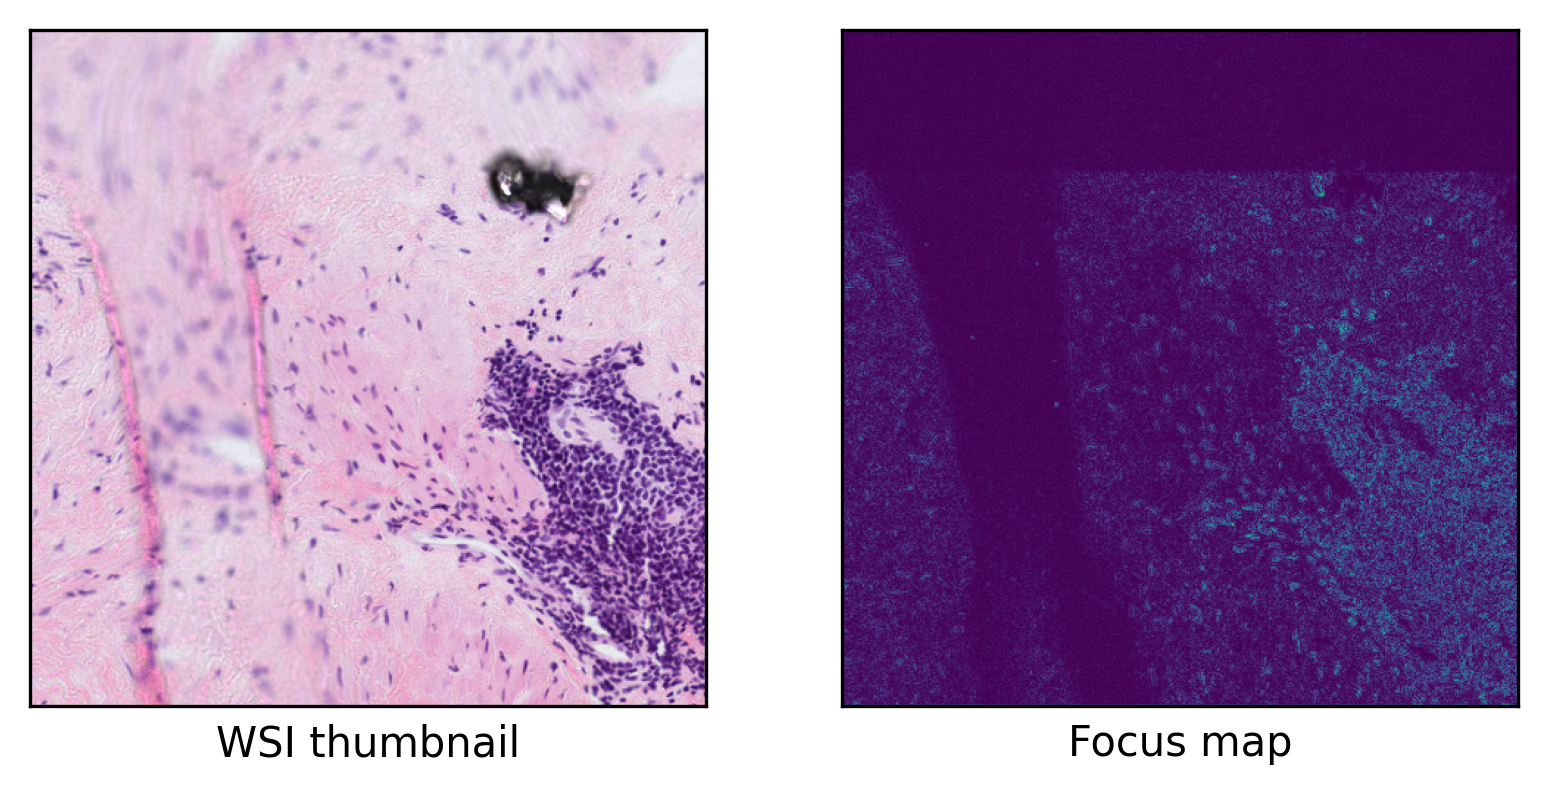

In [ ]:
reader = WSIReader.open(wsi_file_name)
thumb = reader.slide_thumbnail(
    resolution=iostate.save_resolution["resolution"],
    units=iostate.save_resolution["units"],
)
predictions = np.load(wsi_output[0][1] + ".raw.0.npy")
logger.info(
    "Raw prediction dimensions: (%d, %d, %d)",
    predictions.shape[0],
    predictions.shape[1],
    predictions.shape[2],
)

ax = plt.subplot(1, 2, 1)
plt.imshow(thumb), plt.xlabel("WSI thumbnail"), ax.axes.xaxis.set_ticks(
    [],
), ax.axes.yaxis.set_ticks([])
ax = plt.subplot(1, 2, 2)
plt.imshow(predictions[..., -1]), plt.xlabel("Focus map"), ax.axes.xaxis.set_ticks(
    [],
), ax.axes.yaxis.set_ticks([])

As you can see, our model successfully detects focused regions of the input WSI. In this example, we used a small WSI for the sake of low computation but you can test its functionality on any sample of your choice. In any case, the only thing that the user needs to provide is the model (with its weights loaded) and the TIAToolbox will take care of WSI processing, patch extraction, prediction aggregation, and multi-processing handling. When defining your model, you can even add your desired preprocessing function (for example, stain normalization) through the `preproc` method to be applied on each patch prior to inference.

To once again see how easy it is to use an external model in TIAToolbox's semantic segmentation class, we summarize in pseudo-code, as below:

```
# 1- Define the Pytorch model and load weights
model = get_CNN() # model should follow tiatoolbox.model.abc.ModelABC

# 2- Define the segmentor and IOconfig
segmentor = SemanticSegmentor(model=model)
ioconfig = IOSegmentorConfig(...)

# 3- Run the prediction
output = segmentor.predict([img_paths], save_dir, ioconfig, ...)

```

## Injecting pretrained patch classification models

There are two ways in TIAToolbox that you can use your own pretrained classification models. The first way if to use TIAToolbox pretrained classification models, a list of which is available [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=patch_predictor#module-tiatoolbox.models.architecture). With this option, you can override the model weights with your own set of fine-tuned weights via the `pretrained_weights` argument (the argument is case insensitive).

However, sometimes you want to use a pretrained model that has not been implemented in the TIAToolbox framework.
We can use the same principles explained in the previous example to use   an externally pretrained model in the TIAToolbox pipeline. In the example below, we show how to import a native `torchvision` pretrained model (not included in the TIAToolbox repository) and use it in the TIAToolbox patch prediction pipeline.

The first step is to import the model with its weights loaded and then we need to add some methods to the model class  so that it would be suitable for a TIAToolbox pipeline (the model class should follow the `tiatoolbox.models.abc.ModelABC` structure).



In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ],
)

# Define the pretrained model and load the weights
external_model = inception_v3(pretrained=True)
external_model.eval()


# define the methods needed for `tiatoolbox.models.abc.ModelABC abstract` class.
def infer_batch(
    model: torch.nn.Module,
    batch_data: np.ndarray | torch.Tensor,
    *,
    on_gpu: bool,
) -> np.ndarray:
    """Model inference on a batch of images."""
    model.eval()
    device = "cuda" if on_gpu else "cpu"

    imgs = batch_data

    imgs = imgs.to(device).type(torch.float32)

    with torch.inference_mode():
        logits = model(imgs)
        probs = F.softmax(logits, 1)

    return probs.cpu().numpy()


def postproc_func(output: np.ndarray) -> np.ndarray:
    """Pre-processing function."""
    return output


def preproc_func(img: np.ndarray) -> np.ndarray:
    """Post-processing function."""
    pil_image = Image.fromarray(img)
    transformed = transform(pil_image)
    return np.array(transformed)


# add the methods to the `external_model` class
external_model.infer_batch = infer_batch
external_model.preproc_func = preproc_func
external_model.postproc_func = postproc_func

Based on our knowledge of the imported external model, which is an imagenet pretrained `inception_v3` CNN model, and the requirements of the  TIAToolbox friendly model class, we have added `infer_batch`, `postproc_func`, and `preproc_func` methods to the `external_model` class. These functions apply the appropriate pre and post-processing on the image and model predictions, respectively. The design of these functions should be based on the external model and the problem at hand. You can follow the above cell example or the code in the [TIAToolbox UNet architecture](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/tiatoolbox/models/architecture/unet.py) to be inspired and get an idea of what you need to do to suit your application (problem).

Now that we have our `external_model` ready, we just need to define the `IOPatchPredictorConfig` for data control and instantiate the `PatchPredictor`, which can ultimately be used for patch prediction. In the cell below, we have applied the `external_model` to a subset of 4 images from the "ImageNet" dataset.



In [ ]:
external_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

# 3. Define the patch predictor
external_predictor = PatchPredictor(model=external_model, batch_size=64)

# First, find the patch addresses
imagenet_files = list(Path("./tmp/imagenet/").glob("*.jpeg"))

# Now call the predict function on the patches
external_output = external_predictor.predict(
    imgs=imagenet_files,
    mode="patch",
    ioconfig=external_ioconfig,
    return_probabilities=True,
    return_labels=False,
    on_gpu=ON_GPU,
)

100%|#############################################| 1/1 [00:00<00:00,  6.88it/s]


Now let's see if each class has been correctly predicted by showing the sample images and their predictionâ€™s "class:probability".



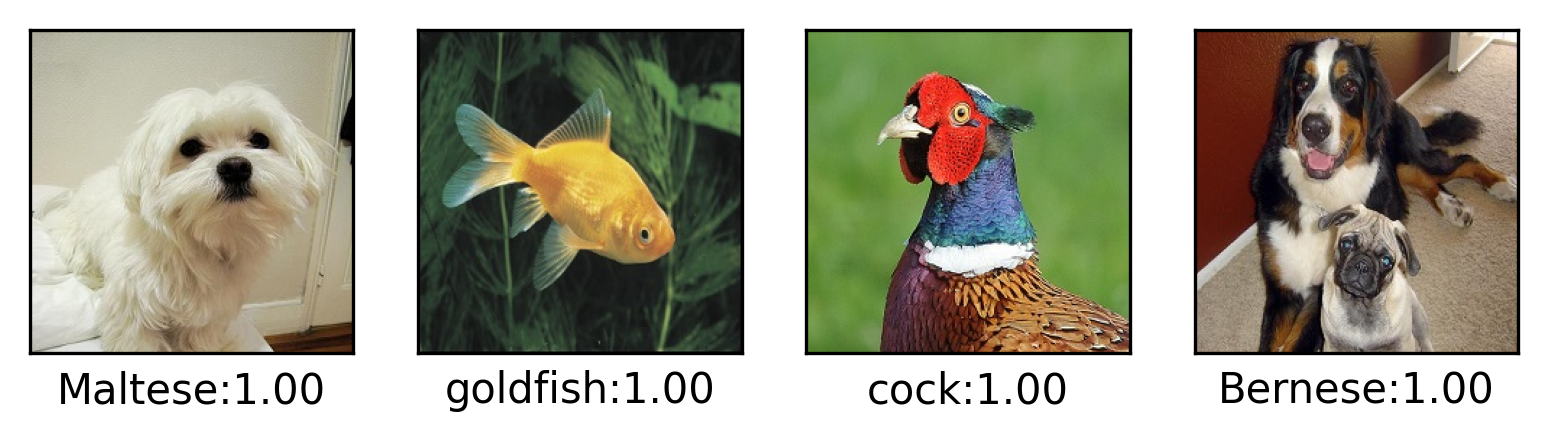

In [ ]:
# Loade imagenet classes
with Path(class_names_file).open() as f:
    classes = [line.strip() for line in f.readlines()]

# Showing the input images and their predicted classes
num_pics = len(imagenet_files)
for i, img_file in enumerate(imagenet_files):
    img = imread(img_file)
    cls_idx = np.argmax(external_output["predictions"][i])
    cls_prob = external_output["predictions"][i][cls_idx]
    cls_name = classes[cls_idx]

    ax = plt.subplot(1, num_pics, i + 1)
    plt.imshow(img), plt.xlabel(
        "{}:{:.2f}".format(cls_name.split(" ")[0], cls_prob),
    ), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])

## 2. Dealing with exotic data formats

To speed up  the inference process for multiple WSIs, TIAToolbox uses `WSIStreamDataset` class to read a wsi in parallel mode with persistent workers. In other words, this class is responsible for providing data to the model during the prediction process. In this class, the `torch.utils.data.Dataloader` is used which is set to run in persistent mode. Normally, this mode will prevent workers from altering their initial states (for example, provided input). To sidestep this, a shared parallel workspace context manager (`mp_shared_space`) is utilized in the TIAToolbox to send data and signals from the main thread, thus allowing each worker to load a new WSI as well as corresponding patch information.

Naturally, the `WSIStreamDataset` only works with the image formats that TIAToolbox supports. A list of supported WSI formats can be found [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html#tiatoolbox.wsicore.wsireader.OpenSlideWSIReader). Also, TIAToolbox supports reading the same types of plane images as OpenCV. So, if you like to work with some external data formats that TIAToolbox does not support, you have to subclass the `WSIStreamDataset` and add your extra bits to it. Various segments may need to be overwritten depending on your application, however, it is important that some portions related to `mp_shared_space` should follow the structure of the original function. Otherwise, you risk breaking the functionality of the predictor.
For example, the first part of `__getitem__` function in `WSIStreamDataset` should remain intact, as below:

```
def __getitem__(self, idx):
    # ! no need to lock as we do not modify source value in shared space
    if self.wsi_idx != self.mp_shared_space.wsi_idx:
        self.wsi_idx = int(self.mp_shared_space.wsi_idx.item())
        self.reader = self._get_reader(self.wsi_path_list[self.wsi_idx])

    bound = self.mp_shared_space.patch_input_list[idx]
    ...
```

because this portion queries the latest signal coming from the main thread via the shared memory space and uses this information to decide which source image to read. Afterwards, the new input location (`bound`) for WSI reading is is also queried through the shared memory space.

In order to better demonstrate how you can read new data formats using TIAToolbox, we present the example below, where we subclass `WSIStreamDataset` to load a 'multiplex tif' tile, although this is not officially supported by TIAToolbox.

First, let's define an image reader function that is capable of loading 'multiplex tif' files.



In [ ]:
def xreader(img_path: str | Path) -> VirtualWSIReader:
    """Multiplex tif image reader."""
    img_path = Path(img_path)
    img = skimread(img_path, plugin="tifffile")
    img = np.transpose(img, axes=[1, 2, 0])
    # initialise metadata for VirtualWSIReader.

    # here we create a virtual whole slide image,
    # with a single level, from the image array
    metadata = WSIMeta(
        mpp=np.array([0.5, 0.5]),
        objective_power=20,
        slide_dimensions=np.array(img.shape[:2][::-1]),
        level_downsamples=[1.0],
        level_dimensions=[np.array(img.shape[:2][::-1])],
        axes="YXS",
    )
    return VirtualWSIReader(img, info=metadata, mode="bool")

Next, we  define a new reader class, called `XReader`, based on the `WSIStreamDataset` class and replace the `_get_reader` internal function to force the class to use `xreader` as its image reader instead of TIAToolbox's `wsireader`. We need to make sure that `XReader`, our new WSI streaming class, is being used in the prediction. Therefore, prior to creating our segmentor, we should subclass the `SemanticSegmentor` class and replace the parts that `xreader` should be used instead of TIAToolbox's `wsireader`, in this case, the `get_reader` function is defined as follows:



In [ ]:
class XReader(WSIStreamDataset):
    """Multiplex image reader as a WSIStreamDataset."""

    def _get_reader(self: WSIStreamDataset, img_path: Path) -> WSIStreamDataset:
        """Get approriate reader for input path."""
        return xreader(img_path)


class XPredictor(SemanticSegmentor):
    """Multiplex image predictor engine."""

    @staticmethod
    def get_reader(
        img_path: str | Path,
        mask_path: str | Path,
        mode: str,
        *,
        auto_get_mask: bool,
    ) -> tuple[WSIReader, WSIReader]:
        """Get reader for mask and source image."""
        img_path = Path(img_path)

        reader = xreader(img_path)
        mask_reader = None
        if mask_path is not None:
            if not Path(mask_path).is_file():
                msg = "`mask_path` must be a valid file path."
                raise ValueError(msg)
            mask = imread(mask_path)  # assume to be gray
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            mask = np.array(mask > 0, dtype=np.uint8)

            mask_reader = VirtualWSIReader(mask)
            mask_reader.info = reader.info
        elif auto_get_mask and mode == "wsi" and mask_path is None:
            # if no mask provided and `wsi` mode, generate basic tissue
            # mask on the fly
            mask_reader = reader.tissue_mask(resolution=1.25, units="power")
            mask_reader.info = reader.info
        return reader, mask_reader

Now that we have both new `XReader` and `XPredictor` classes in place, we can use the prediction framework of TIAToolbox to do inference on input images. To test if our data loader class can successfully load the images, we create a temporary model, called `XModel`, based on the `BlurModel` from the previous section.We will overwrite the `forward` function so that it returns its own input. Returning model input as the output allows us to check what our model sees in the input. As this is basically the same model, we can use the same `IOSegmentorConfig` as before:



In [ ]:
class XModel(BlurModel):
    """Dummy XModel based on BlurModel."""

    def forward(self: BlurModel, img_list: np.ndarray) -> np.ndarray:
        """Model forward function."""
        return img_list


iostate = IOSegmentorConfig(
    input_resolutions=[
        {"units": "baseline", "resolution": 1.0},
    ],
    output_resolutions=[
        {"units": "baseline", "resolution": 1.0},
    ],
    patch_input_shape=[512, 512],
    patch_output_shape=[512, 512],
    stride_shape=[256, 256],
    save_resolution={"units": "baseline", "resolution": 1.0},
)

Everything is in place. Let's instantiate our model segmentor, and start the prediction. Here we predict from a 'tif' image file that we have downloaded before and save the results in the
`./tmp/xdata_prediction/` directory:



In [ ]:
rmdir("./tmp/xdata_prediction/")  # remove directories from previous runs
model = XModel()
predictor = XPredictor(model=model, dataset_class=XReader)
x_output = predictor.predict(
    [img_file_name],
    mode="tile",
    on_gpu=ON_GPU,
    ioconfig=iostate,
    crash_on_exception=True,
    save_dir="./tmp/xdata_prediction/",
)

Process Batch: 100%|##############################| 3/3 [00:02<00:00,  1.45it/s]
INFO:root:Finish: 0
INFO:root:--Input: ./tmp/sample_tile.tif
INFO:root:--Output: /content/tmp/xdata_prediction/0


Now we check the prediction (model's output) and source image to see if we have created the pipeline in the right way (input and output images should be the same).



INFO:root:Overview dimensions: (992, 1328, 8)
INFO:root:Raw prediction dimensions: (992, 1328, 8)


(<matplotlib.image.AxesImage at 0x78f8f5ea9e10>,
 Text(0.5, 0, 'Model`s Input/Output'),
 [],
 [])

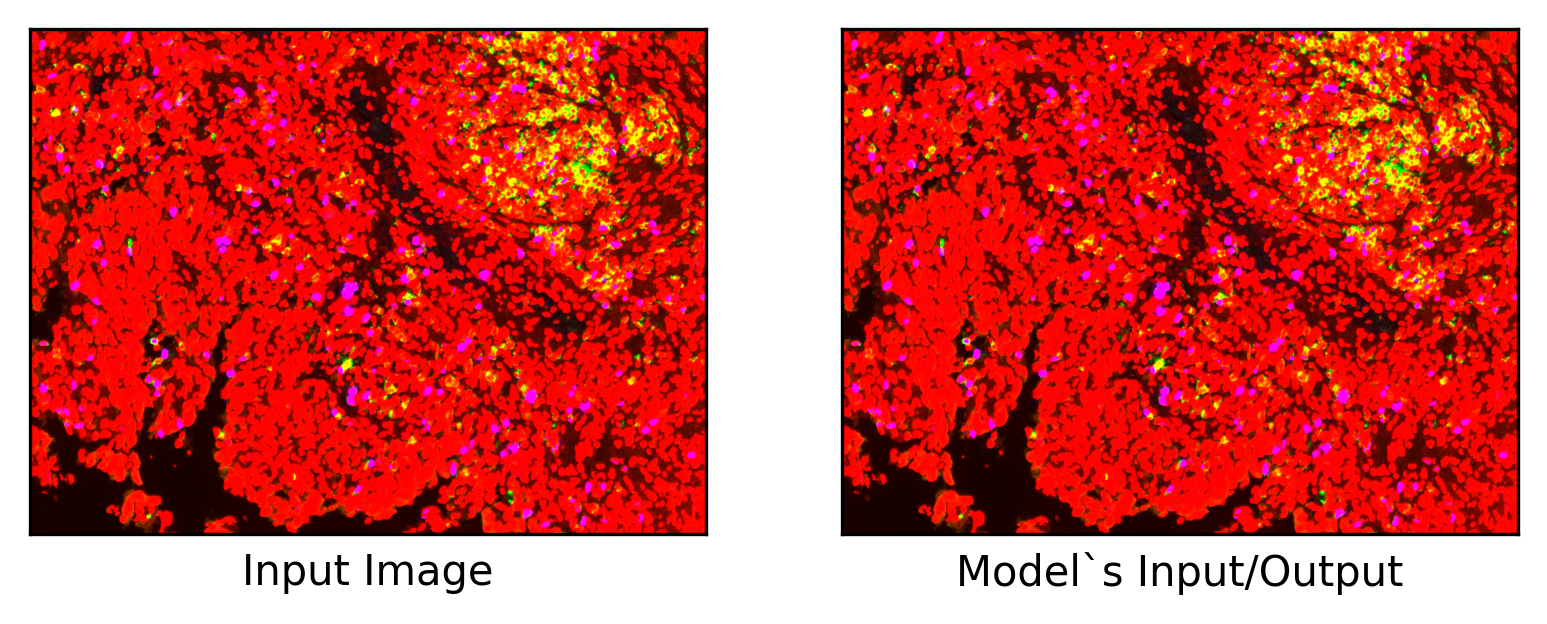

In [ ]:
reader = xreader(img_file_name)
thumb = reader.slide_thumbnail(
    resolution=iostate.save_resolution["resolution"],
    units=iostate.save_resolution["units"],
)
logger.info(
    "Overview dimensions: (%d, %d, %d)",
    thumb.shape[0],
    thumb.shape[1],
    thumb.shape[2],
)

predictions = np.load(x_output[0][1] + ".raw.0.npy")
logger.info(
    "Raw prediction dimensions: (%d, %d, %d)",
    predictions.shape[0],
    predictions.shape[1],
    predictions.shape[2],
)

ax = plt.subplot(1, 2, 1)
plt.imshow(thumb[..., :3]), plt.xlabel("Input Image"), ax.axes.xaxis.set_ticks(
    [],
), ax.axes.yaxis.set_ticks([])
ax = plt.subplot(1, 2, 2)
plt.imshow(predictions[..., :3]), plt.xlabel(
    "Model`s Input/Output",
), ax.axes.xaxis.set_ticks([]), ax.axes.yaxis.set_ticks([])